# Driving styles and car type

In [3]:
import os
os.chdir('../data')

In [4]:
import scipy
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM

In [119]:
driving_data = pd.read_csv("input/results-survey528393.csv")

In [120]:
print("Driving data", driving_data.shape)

Driving data (39, 334)


## Preprocessing

Get results from the driving style scale that each participant responded.

In [121]:
# group column names of aggressive and defensive conditions.
aggressive = driving_data.columns[driving_data.columns.str.fullmatch("agg[^2]+\[SQ00[1-2]\]")]
aggressive2 = driving_data.columns[driving_data.columns.str.fullmatch("agg.+2\[SQ00[1-2]\]")]

defensive = driving_data.columns[driving_data.columns.str.fullmatch("def[^2]+\[SQ00[1-2]\]")]
defensive2 = driving_data.columns[driving_data.columns.str.fullmatch("def.+2\[SQ00[1-2]\]")]

In [122]:
aggressive

Index(['aggpassenger[SQ001]', 'aggpassenger[SQ002]', 'aggdriver[SQ001]',
       'aggdriver[SQ002]', 'aggrural[SQ001]', 'aggrural[SQ002]',
       'aggurban[SQ001]', 'aggurban[SQ002]', 'aggfamily[SQ001]',
       'aggfamily[SQ002]', 'aggsports[SQ001]', 'aggsports[SQ002]'],
      dtype='object')

In [123]:
driving_data.loc[:, "aggmean"] = driving_data.loc[:, aggressive].mean(axis=1)
driving_data.loc[:, "aggmean2"] = driving_data.loc[:, aggressive2].mean(axis=1)
driving_data.loc[:, "defmean"] = driving_data.loc[:, defensive].mean(axis=1)
driving_data.loc[:, "defmean2"] = driving_data.loc[:, defensive2].mean(axis=1)

driving_data.loc[:, "assertive"] = driving_data.loc[:, ["aggmean", "aggmean2"]].mean(axis=1)    # it is called "assertive" in the ref paper.
driving_data.loc[:, "defensive"] = driving_data.loc[:, ["defmean", "defmean2"]].mean(axis=1)

In [124]:
# keep only condition = 3, which explores car type
car_type_data = driving_data[driving_data["condition"] == 3]

# delete columns with all null values
car_type_data = driving_data.dropna(axis=1, how="all")


In [125]:
driving_data.to_pickle("working/driving_data.pkl")
car_type_data.to_pickle("working/car_type_data.pkl")


## Descriptive statistics

In [126]:
descriptive_columns = [
    "drivingxpcat",
    "educationyears",
    "age",
    "gender",
    "drivingxp",
    "educationlevel",
]

In [118]:
driving_data = pd.read_pickle("working/driving_data.pkl")
car_type_data = pd.read_pickle("working/car_type_data.pkl")

In [40]:
driving_data.head()

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,consent,consent2,generatecode,...,BFI10Time,groupTime182,TraitOfAnx1Time,groupTime145,SensationArrayTime,TrustArrayTime,groupTime177,participationhoursTime,groupTime188,FeedbackTime
0,57,2022-06-19 20:47:02,47,en,1350102654,2022-06-19 20:20:56,2022-06-19 20:47:02,NaN,I agree.,JJ08H,...,NaN,NaN,125.43,NaN,NaN,NaN,NaN,3.54,NaN,91.35
1,67,2022-06-20 14:47:37,47,en,349158379,2022-06-20 14:34:51,2022-06-20 14:47:37,NaN,I agree.,FN06M,...,40.97,NaN,NaN,NaN,NaN,NaN,NaN,264.72,NaN,10.22
2,101,2022-06-20 19:15:32,47,en,1846708769,2022-06-20 19:01:06,2022-06-20 19:15:32,NaN,I agree.,RL06D,...,NaN,NaN,71.31,NaN,NaN,NaN,NaN,45.64,NaN,23.86
3,104,2022-06-20 22:18:28,47,en,452194193,2022-06-20 21:57:43,2022-06-20 22:18:28,NaN,I agree.,CH01W,...,NaN,NaN,105.07,NaN,NaN,NaN,NaN,19.25,NaN,5.31
4,106,2022-06-20 22:25:31,47,en,1969376775,2022-06-20 22:14:37,2022-06-20 22:25:31,NaN,I agree.,FA12T,...,NaN,NaN,61.35,NaN,NaN,NaN,NaN,17.70,NaN,7.78


**Conditions**

[]

## Plot the data

In [59]:
# confidence interval of paired t-test
"difference in means +- t(n-1, 0.05) * se(mean) / sqrt(n)"


def t_ci(data, alpha=0.05):
    t, p = scipy.stats.ttest_rel(data[0], data[1])
    ci = scipy.stats.t.ppf(1-alpha/2, np.abs(t))    # is this the same? (automatically generated)
    return ci

# modify this
def confidence_interval_bar(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    error_bar = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return error_bar

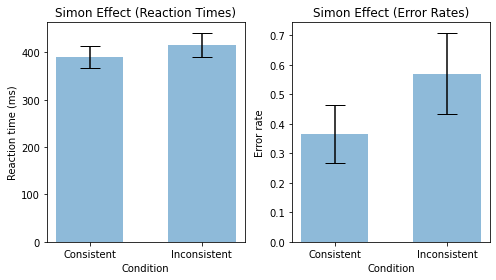

In [72]:
# Build the plot
figure, axis = plt.subplots(1, 2, figsize=(7, 4))

# Reaction times
consistent_mean = np.mean(reaction_times["NC"])
inconsistent_mean = np.mean(reaction_times["NI"])

consistent_std = np.std(reaction_times["NC"])
inconsistent_std = np.std(reaction_times["NI"])

conditions = ["Consistent", "Inconsistent"]
x_pos = np.arange(len(conditions))
CTEs = [consistent_mean, inconsistent_mean]
error = [confidence_interval_bar(reaction_times["NC"]), confidence_interval_bar(reaction_times["NI"])]

axis[0].bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.6)
axis[0].set_xlabel('Condition')
axis[0].set_ylabel('Reaction time (ms)')
axis[0].set_xticks(x_pos)
axis[0].set_xticklabels(conditions)
axis[0].set_title('Simon Effect (Reaction Times)')

# Error rates
consistent_mean = np.mean(error_rates["NC"])
inconsistent_mean = np.mean(error_rates["NI"])

consistent_std = np.std(error_rates["NC"])
inconsistent_std = np.std(error_rates["NI"])

conditions = ["Consistent", "Inconsistent"]
x_pos = np.arange(len(conditions))
CTEs = [consistent_mean, inconsistent_mean]
error = [confidence_interval_bar(error_rates["NC"]), confidence_interval_bar(error_rates["NI"])]

axis[1].bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.6)
axis[1].set_xlabel('Condition')
axis[1].set_ylabel('Error rate')
axis[1].set_xticks(x_pos)
axis[1].set_xticklabels(conditions)
axis[1].set_title('Simon Effect (Error Rates)')

plt.tight_layout()
plt.show()

## Repeated measures ANOVA??

In [46]:
# unpivot dataframes
reaction_times = pd.melt(reaction_times, id_vars=["subject"], value_vars=["NC", "NI"])
error_rates = pd.melt(error_rates, id_vars=["subject"], value_vars=["NC", "NI"])
reaction_times.sample(5)

,subject,variable,value
4,5,NC,376.979452
18,8,NI,375.634328
16,6,NI,448.746154
15,5,NI,413.185714
17,7,NI,462.722628


In [12]:
print("Reaction times:")
print(AnovaRM(data=reaction_times, depvar="value", subject="subject", within=['variable']).fit())
print("Error rates:")
print(AnovaRM(data=error_rates, depvar="value", subject="subject", within=['variable']).fit())

Reaction times:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable 21.8033 1.0000 10.0000 0.0009

Error rates:
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable 14.5310 1.0000 10.0000 0.0034

